# Clase 4. Preparación de datos. Sección 3. Imputación de datos faltantes 

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](https://docs.google.com/presentation/d/1lBF-w7pShz5fd4-LQZvsIUnHJwPomvdqlVNyKYM9Q-M/edit?usp=sharing).

Ejemplos organizados por sección:

- Imputación estadística
- MICE
- KNN

In [3]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:0.24.2
Numpy:1.15.4
Matplotlib:3.0.3
SKlearn:0.24.1
Seaborn:0.9.0



Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

 COVID-19-geographic-disbtribution-worldwide-2020-06-29.xlsx
 diabetes.csv
 diabetes_ex.csv
 houseprices.csv
'NSIT Dwarka.csv'
 subset-covid-data.csv
 titanic.csv


## 1. Preparación de datos

Carga de datasets utilizados para ejemplos.

Precios de propiedades.

In [3]:
df_houseprice = pd.read_csv(DATASET_PATH+"/houseprices.csv")
df_houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Titanic.

In [4]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

## 3. Imputación de datos faltantes

In [6]:
df = pd.read_csv(DATASET_PATH+'/diabetes_ex.csv')
df.drop('Hospital',axis=1,inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,89.0,24.0,19.0,25.0,27.8,0.559,21.0,0.0
1,1.0,151.0,60.0,0.0,0.0,26.1,NaN,22.0,0.0
2,1.0,93.0,56.0,11.0,0.0,22.5,0.417,22.0,0.0
3,3.0,NaN,78.0,0.0,0.0,42.7,0.559,21.0,0.0
4,2.0,108.0,64.0,0.0,0.0,30.8,0.158,21.0,0.0


In [7]:
# Filas con y nulo
len(df[df['Outcome'].isna()])

41

In [8]:
# Remover filas con y nulo
df = df[df['Outcome'].notna()]
df.isnull().sum()

Pregnancies                 31
Glucose                     28
BloodPressure               27
SkinThickness               35
Insulin                     34
BMI                         40
DiabetesPedigreeFunction    35
Age                         43
Outcome                      0
dtype: int64

### 3.1 Imputación estadística 

- La imputación estadística consiste en reemplazar los valores faltantes en una columna por una estadística (imputación univariada).
- Usaremos *SimpleImputer* de SKLearn para imputar por:
    - Promedio
    - Mediana
    - Moda
    - Constante
    
- En este ejemplo se compara el efecto de distintas estrategias de imputación con un esquema de entrenamiento K-Folds.   

In [9]:
from sklearn.impute import SimpleImputer

X = df.values[:, :-1] # Todas las filas, todas las columnas menos la última

# Promedio
imputer = SimpleImputer(strategy='mean',add_indicator=True)
X_imputed_mean = imputer.fit_transform(X)

# Nuevo dataframe con X e indicadores de valores imputados
X_cols = df.columns.difference(['Outcome'])
X_cols = list(X_cols)+["%s_imputed" % x for x in X_cols]
X_imputed_mean = pd.DataFrame(X_imputed_mean,columns=X_cols)

assert(not np.any(X_imputed_mean.isnull().sum()>0))

X_imputed_mean[X_imputed_mean.Age_imputed==True].head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness,Age_imputed,BMI_imputed,BloodPressure_imputed,DiabetesPedigreeFunction_imputed,Glucose_imputed,Insulin_imputed,Pregnancies_imputed,SkinThickness_imputed
23,3.828816,109.0,38.0,18.0,120.0,23.1,0.407,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,3.828816,108.0,68.0,20.0,0.0,27.3,0.787,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,3.828816,108.0,70.0,0.0,0.0,30.5,0.955,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,3.828816,89.0,66.0,23.0,94.0,28.1,0.167,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,3.828816,94.0,0.0,0.0,0.0,0.0,0.256,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Moda
imputer = SimpleImputer(strategy='most_frequent',add_indicator=True)

X_imputed_mode = imputer.fit_transform(X)
X_imputed_mode = pd.DataFrame(X_imputed_mode,columns=X_cols)

assert(not np.any(X_imputed_mode.isnull().sum()>0))

X_imputed_mode[X_imputed_mode.Age_imputed==True].head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness,Age_imputed,BMI_imputed,BloodPressure_imputed,DiabetesPedigreeFunction_imputed,Glucose_imputed,Insulin_imputed,Pregnancies_imputed,SkinThickness_imputed
23,1.0,109.0,38.0,18.0,120.0,23.1,0.407,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,1.0,108.0,68.0,20.0,0.0,27.3,0.787,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,1.0,108.0,70.0,0.0,0.0,30.5,0.955,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,1.0,94.0,0.0,0.0,0.0,0.0,0.256,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Constante
imputer = SimpleImputer(strategy='constant',fill_value=0,add_indicator=True)

X_imputed_constant = imputer.fit_transform(X)
X_imputed_constant = pd.DataFrame(X_imputed_constant,columns=X_cols)

assert(not np.any(X_imputed_constant.isnull().sum()>0))

X_imputed_constant[X_imputed_constant.Age_imputed==True].head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness,Age_imputed,BMI_imputed,BloodPressure_imputed,DiabetesPedigreeFunction_imputed,Glucose_imputed,Insulin_imputed,Pregnancies_imputed,SkinThickness_imputed
23,0.0,109.0,38.0,18.0,120.0,23.1,0.407,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,108.0,68.0,20.0,0.0,27.3,0.787,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,108.0,70.0,0.0,0.0,30.5,0.955,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,94.0,0.0,0.0,0.0,0.0,0.256,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from sklearn.model_selection import train_test_split

X = df[['Age','DiabetesPedigreeFunction','BMI','Insulin','Pregnancies']].values[:, :-1]
y = df.values[:, -1]
#X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

Búsqueda de mejores parámetros por Grid Search.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ( 'imputer' ,SimpleImputer()), 
    ( 'lr' , LogisticRegression() )
])

param_grid = {
    "imputer__strategy": ['most_frequent', 'mean','constant','median' ],
    "lr__max_iter": [1000]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
search = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=cv)
results =search.fit(X,y)

In [14]:
print('Mejor Puntaje (Accuracy): %.3f ' % results.best_score_)
print('Mejor parámetro: %s ' % results.best_params_)

Mejor Puntaje (Accuracy): 0.690 
Mejor parámetro: {'imputer__strategy': 'median', 'lr__max_iter': 1000} 


Comparación de resultados por K-Folds.

In [15]:
from sklearn.model_selection import cross_val_score

results=[]
for param in param_grid["imputer__strategy"]:
    pipeline = Pipeline(steps=[
        ( 'imputer' ,SimpleImputer(strategy=param)), 
        ( 'lr' , LogisticRegression(max_iter=1000) )
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)

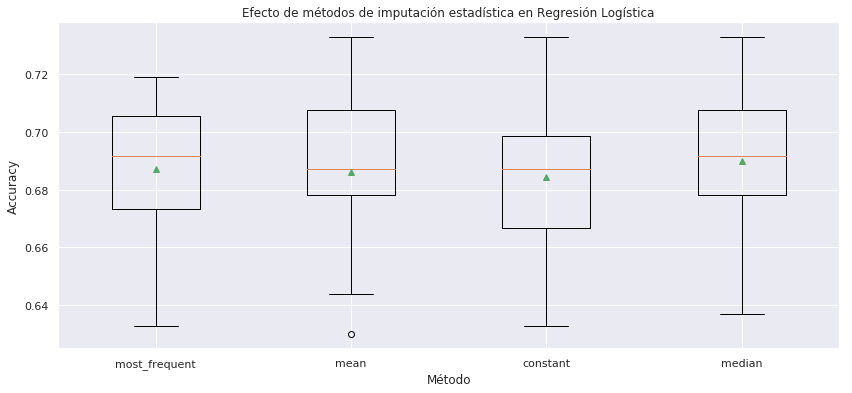

In [16]:
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=param_grid["imputer__strategy"],showmeans=True)
axes.set_xlabel("Método")
axes.set_ylabel("Accuracy")
axes.set_title("Efecto de métodos de imputación estadística en Regresión Logística");

### 3.2 Imputación por vecinos cercanos (KNN)

- Se calculan valores faltantes a partir del algoritmo KNN utilizando el promedio de las columnas más próximas (para la distancia generalmente se utiliza nan_euclidean_distance).

#### 3.2.1 Pasos

In [9]:
music_df = pd.DataFrame({
    "Metallica": [80,44,np.nan,50,29],
    "Luis Miguel": [30,np.nan,85,70,54],
    "Astor Piazzolla": [7,10,25,74,49],
    "Jimi Hendrix": [27,29,88,49,np.nan]
})
music_df

,Metallica,Luis Miguel,Astor Piazzolla,Jimi Hendrix
0,80.0,30.0,7,27.0
1,44.0,NaN,10,29.0
2,NaN,85.0,25,88.0
3,50.0,70.0,74,49.0
4,29.0,54.0,49,NaN


In [10]:
from sklearn.metrics.pairwise import nan_euclidean_distances
#dist(x,y) = sqrt(weight * sq. distance from present coordinates) 
#where, weight = Total # of coordinates / # of present coordinates

row_to_impute = music_df.iloc[2]
feature_cols = ['Metallica', 'Luis Miguel', 'Astor Piazzolla', 'Jimi Hendrix']
music_df['nan_euc_dist'] = music_df[feature_cols].apply(
    lambda row: nan_euclidean_distances( row_to_impute.values.reshape(1,-1),
           row.values.reshape(1,-1))[0][0],axis=1)
music_df

,Metallica,Luis Miguel,Astor Piazzolla,Jimi Hendrix,nan_euc_dist
0,80.0,30.0,7,27.0,97.091023
1,44.0,NaN,10,29.0,86.092973
2,NaN,85.0,25,88.0,0.000000
3,50.0,70.0,74,49.0,74.359487
4,29.0,54.0,49,NaN,55.443665


In [7]:
(50+29)/2

39.5

#### 3.2.2 Ejemplo con Titanic

In [17]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
# Codificación (visto en sección 2)
df_titanic['cabin_red'] = df_titanic['Cabin'].astype(str).str[0]
cabin_red_dict = {k: i for i, k in enumerate(df_titanic['cabin_red'].unique(), 0)}
df_titanic.loc[:, 'cabin_mapped_red'] = df_titanic.loc[:, 'cabin_red'].map(cabin_red_dict)
df_titanic.loc[:, 'Sex'] = df_titanic.loc[:, 'Sex'].map({'male': 0, 'female': 1})

X = df_titanic[['Age','Fare','Sex','cabin_mapped_red']].values
y = df_titanic.Survived.values

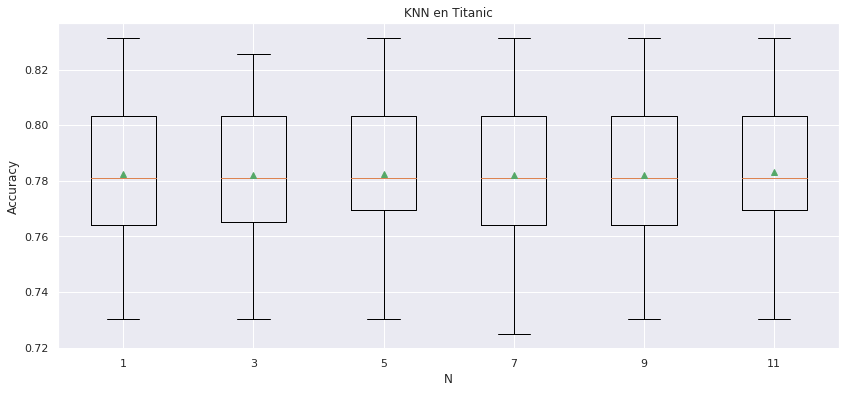

In [19]:
#!python3 -m pip install scikit-learn --user --upgrade pip
#from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer

results=[]

param_grid = {
    "imputer__n_neighbors": [1,3,5,7,9,11 ]
}

for param in param_grid["imputer__n_neighbors"]:
    pipeline = Pipeline(steps=[
        ( 'imputer' ,KNNImputer(n_neighbors=param)), 
        ( 'lr' , LogisticRegression(max_iter=1000) )
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)
    
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=param_grid["imputer__n_neighbors"],showmeans=True)
axes.set_xlabel("N")
axes.set_ylabel("Accuracy")
axes.set_title("KNN en Titanic");        

In [20]:
param_idx = np.array([x.mean() for x in results]).argmin()
param_mean_acc = results[param_idx].mean()
print("Mejor accuracy (promedio): ", param_mean_acc)

Mejor accuracy (promedio):  0.7820475801895675


### 3.3 Multiple Imputation by Chained Equations (MICE)

- Calcula valores faltantes para cada columna como una regresión lineal de las restantes (si bien también se pueden usar otros modelos). Como utiliza el resto de las columnas, es un método **multivariado**.
- Es iterativo porque repite este proceso hasta que la diferencia entre las dos últimas iteraciones sea cercana a cero.
- Algoritmo (pizarra).
- Referencia: [Multiple imputation by chained equations: what is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)

#### 3.3.1 Pasos

Un banco tiene una base de datos de clientes que compraron una tarjeta de crédito.

Quiere desarrollar un modelo si el cliente es un potencial comprador o no.

Las siguientes variables de entrada son:
  - Edad
  - Experiencia
  - Salario
y la salida es 0. Si no compró, y 1 si compró.

Ejemplo adaptado de: https://www.youtube.com/watch?v=WPiYOS3qK70

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = pd.DataFrame({
    "age":        [ 25,27,29,31,33, 35],
    "experience": [ 1, 3,5,7,9,11],
    "salary":     [ 50,80,110,140,170,200],
    "purchased":  [ 0,1,1,0,1,0]
})

df

,age,experience,salary,purchased
0,25,1,50,0
1,27,3,80,1
2,29,5,110,1
3,31,7,140,0
4,33,9,170,1
5,35,11,200,0


El problema es que por un error de sistemas, algunos valores de la DB se perdieron.

In [12]:
df_missing = pd.DataFrame({
    "age":        [ 25,27,29,31,33, np.nan],
    "experience": [ np.nan, 3,5,7,9,11],
    "salary":     [ 50,np.nan,110,140,170,200],
    "purchased":  [ 0,1,1,0,1,0]
})
df_missing

,age,experience,salary,purchased
0,25.0,NaN,50.0,0
1,27.0,3.0,NaN,1
2,29.0,5.0,110.0,1
3,31.0,7.0,140.0,0
4,33.0,9.0,170.0,1
5,NaN,11.0,200.0,0


In [13]:
feature_cols = ["age","experience","salary"]
target_col = 'purchased'
df_missing[feature_cols]

,age,experience,salary
0,25.0,NaN,50.0
1,27.0,3.0,NaN
2,29.0,5.0,110.0
3,31.0,7.0,140.0
4,33.0,9.0,170.0
5,NaN,11.0,200.0


Paso 1. Imputar por promedio.

In [15]:
df_0 = df_missing[feature_cols].copy()
df_0.loc[df_0.age.isna(),'age'] = df_0.age.mean()
df_0.loc[df_0.experience.isna(),'experience'] = df_0.experience.mean()
df_0.loc[df_0.salary.isna(),'salary'] = df_0.salary.mean()
df_0

,age,experience,salary
0,25.0,7.0,50.0
1,27.0,3.0,134.0
2,29.0,5.0,110.0
3,31.0,7.0,140.0
4,33.0,9.0,170.0
5,29.0,11.0,200.0


Paso 2. Predecir las filas faltantes de 'age' utilizando el resto de las columnas. Por ejemplo, con LR.

In [16]:
df_1 = df_0.copy()
col_to_impute = 'age'
df_1.loc[df_missing[col_to_impute].isna(),col_to_impute] = np.nan
df_1

,age,experience,salary
0,25.0,7.0,50.0
1,27.0,3.0,134.0
2,29.0,5.0,110.0
3,31.0,7.0,140.0
4,33.0,9.0,170.0
5,NaN,11.0,200.0


In [17]:
def impute_column(df, col_to_predict, feature_columns):
  """ Imputar valores faltantes de una columna a partir de un 
      modelo LR sobre columnas restantes
  """
  nan_rows = np.where(np.isnan(df[col_to_predict]))
  all_rows = np.arange(0,len(df))
  train_rows_idx = np.argwhere(~np.isin(all_rows,nan_rows)).ravel()
  pred_rows_idx =  np.argwhere(np.isin(all_rows,nan_rows)).ravel()
  
  X_train,y_train = df[feature_columns].iloc[train_rows_idx],df[col_to_predict].iloc[train_rows_idx]
  X_pred = df[feature_columns].iloc[pred_rows_idx]

  model = LinearRegression()
  model.fit(X_train,y_train)
  df[col_to_predict].iloc[pred_rows_idx] = model.predict(X_pred.values.reshape(1,-1))
  return df

In [18]:
col_to_impute = 'age'
tmp_feature_cols = [x for x in feature_cols if x != col_to_impute] 
df_1.loc[df_missing[col_to_impute].isna(),col_to_impute] = np.nan
df_1 = impute_column(df_1, col_to_impute, tmp_feature_cols)
df_1

,age,experience,salary
0,25.000000,7.0,50.0
1,27.000000,3.0,134.0
2,29.000000,5.0,110.0
3,31.000000,7.0,140.0
4,33.000000,9.0,170.0
5,36.253165,11.0,200.0


In [19]:
col_to_impute = 'experience'
tmp_feature_cols = [x for x in feature_cols if x != col_to_impute] 
df_1.loc[df_missing[col_to_impute].isna(),col_to_impute] = np.nan
df_1 = impute_column(df_1, col_to_impute, tmp_feature_cols)
df_1

,age,experience,salary
0,25.000000,1.853863,50.0
1,27.000000,3.000000,134.0
2,29.000000,5.000000,110.0
3,31.000000,7.000000,140.0
4,33.000000,9.000000,170.0
5,36.253165,11.000000,200.0


In [20]:
col_to_impute = 'salary'
tmp_feature_cols = [x for x in feature_cols if x != col_to_impute] 
df_1.loc[df_missing[col_to_impute].isna(),col_to_impute] = np.nan
df_1 = impute_column(df_1, col_to_impute, tmp_feature_cols)
df_1

,age,experience,salary
0,25.000000,1.853863,50.00000
1,27.000000,3.000000,72.77481
2,29.000000,5.000000,110.00000
3,31.000000,7.000000,140.00000
4,33.000000,9.000000,170.00000
5,36.253165,11.000000,200.00000


In [21]:
df_1

,age,experience,salary
0,25.000000,1.853863,50.00000
1,27.000000,3.000000,72.77481
2,29.000000,5.000000,110.00000
3,31.000000,7.000000,140.00000
4,33.000000,9.000000,170.00000
5,36.253165,11.000000,200.00000


In [22]:
df_0

,age,experience,salary
0,25.0,7.0,50.0
1,27.0,3.0,134.0
2,29.0,5.0,110.0
3,31.0,7.0,140.0
4,33.0,9.0,170.0
5,29.0,11.0,200.0


In [23]:
df_1 - df_0

,age,experience,salary
0,0.000000,-5.146137,0.00000
1,0.000000,0.000000,-61.22519
2,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.00000
5,7.253165,0.000000,0.00000


#### 3.3.2 Ejemplo con Titanic

In [21]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")

# Codificación (visto en sección 2)
df_titanic['cabin_red'] = df_titanic['Cabin'].astype(str).str[0]
cabin_red_dict = {k: i for i, k in enumerate(df_titanic['cabin_red'].unique(), 0)}
df_titanic.loc[:, 'cabin_mapped_red'] = df_titanic.loc[:, 'cabin_red'].map(cabin_red_dict)
df_titanic.loc[:, 'Sex'] = df_titanic.loc[:, 'Sex'].map({'male': 0, 'female': 1})

X = df_titanic[['Age','Fare','Sex','cabin_mapped_red']].values
y = df_titanic.Survived.values

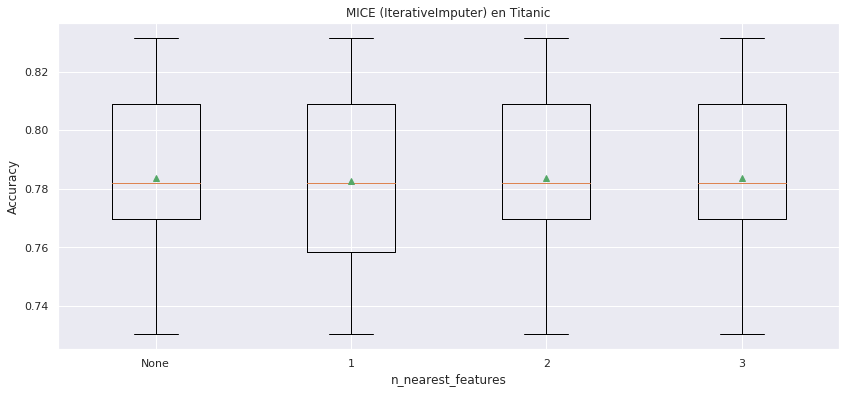

In [22]:
#!python3 -m pip install scikit-learn --user --upgrade pip
#from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

results=[]

param_grid = {
    "imputer__n_nearest_features": [None,1,2,3]
}

for param in param_grid["imputer__n_nearest_features"]:
    pipeline = Pipeline(steps=[
        ( 'imputer' ,IterativeImputer(n_nearest_features=param)), 
        ( 'lr' , LogisticRegression(max_iter=1000) )
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)
    
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=
    [x or "None" for x in param_grid["imputer__n_nearest_features"]],showmeans=True)
axes.set_xlabel("n_nearest_features")
axes.set_ylabel("Accuracy")
axes.set_title("MICE (IterativeImputer) en Titanic");    

In [23]:
param_idx = np.array([x.mean() for x in results]).argmin()
param_mean_acc = results[param_idx].mean()
print("Mejor accuracy (promedio): ", param_mean_acc)

Mejor accuracy (promedio):  0.7827192266649928
